# Machine Learning (M606B) Final Project

Student Name: Seyyed Jalal Tabatabaee<br/>
Student ID: GH1033801<br/>
Github Link: https://github.com/shayantabatabaee/shark-attacks-classification <br/>
Dataset Link: https://www.kaggle.com/datasets/gauravkumar2525/shark-attacks/data

## Introduction

This Jupyter notebook is part of the final project for the machine learning course at Gisma University of Applied Sciences. It aims to apply traditional machine learning methods to the <b>Shark Attacks</b> dataset. The Global Shark Attacks Dataset provides a detailed record of human-shark interactions worldwide. It includes information like the date, location, type of attack, activity of the person, shark species involved, and whether the attack was fatal. As the author noted, this dataset is useful for researchers, marine biologists, conservationists, and enthusiasts who want to study shark behavior, understand attack patterns, and improve ocean safety.

In the first part of this notebook, I will install the required dependencies and load the data. Next, we will check how clean the dataset is and, if needed, I will apply a cleaning pipeline and best practices to prepare the dataset. In the last part, machine learning methods will be used on the dataset for a classification task, and the best model among them will be saved. Finally, the classification metrics and overall evaluation will be described in detail.

## Install Libraries

In [95]:
!pip install kagglehub
!pip install pandas
!pip install missingno
!pip install geopy
!pip install tqdm
!pip install feature_engine

## Import Libraries

In [123]:
import kagglehub
import os
import pandas as pd
import time
from tqdm.notebook import tqdm
import missingno as msno
import re
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from feature_engine.encoding import RareLabelEncoder

# Data Preprocessing

## Download Dataset

In [23]:
dataset_path = kagglehub.dataset_download("gauravkumar2525/shark-attacks")
print("Path to dataset files:", dataset_path)
print("Dataset Filename:", os.listdir(dataset_path)[0])

Path to dataset files: /Users/shayantabatabaee/.cache/kagglehub/datasets/gauravkumar2525/shark-attacks/versions/1
Dataset Filename: global_shark_attacks.csv


## Load Dataset

In [24]:
data = pd.read_csv(os.path.join(dataset_path, os.listdir(dataset_path)[0]))
print("Data loaded successfully!")
print(f"Dataset shape: {data.shape}")
data.head()

Data loaded successfully!
Dataset shape: (6890, 13)


,date,year,type,country,area,location,activity,name,sex,age,fatal_y_n,time,species
0,2023-05-13,2023.0,Unprovoked,AUSTRALIA,South Australia,Elliston,Surfing,Simon Baccanello,M,46,Y,10h10,White shark
1,2023-04-29,2023.0,Unprovoked,AUSTRALIA,Western Australia,"Yallingup, Busselton",Swimming,male,M,NaN,N,11h20,1m shark
2,2022-10-07,2022.0,Unprovoked,AUSTRALIA,Western Australia,Port Hedland,Spearfishing,Robbie Peck,M,38,N,11h30,Bull shark
3,2021-10-04,2021.0,Unprovoked,USA,Florida,"Fort Pierce State Park, St. Lucie County",Surfing,Truman Van Patrick,M,25.0,N,NaN,NaN
4,2021-10-03,2021.0,Unprovoked,USA,Florida,"Jensen Beach, Martin County",Swimming,male,M,NaN,N,12h00,NaN


## Clean Dataset

In this section, I will first check if there are any missing values. I will also look at the data type for each column. If the data type is numerical and there are no missing values, we’re ready to move forward, but later we’ll need to check the distribution of the data to see if there are too many zeros. If the data type is object and categorical, we’ll check each value in the column to ensure they make sense. The most helpful library for getting insights about all features at once is <i>missingno</i>. Let's first check our targets i.e. <i>fatal_y_n</i> column and remove if there is nonsense values. Next I will check the NaN and empty values for all features using this library.

In [30]:
data['fatal_y_n'].value_counts()

fatal_y_n
N          4804
Y          1447
UNKNOWN     631
F             3
y             1
Y x 2         1
n             1
2017.0        1
Nq            1
Name: count, dtype: int64

As we can see, there are 631 UNKNOWN values which we can remove the rows. Also for example there are 3 F and 1 y which we can combine with N and Y targets.

In [35]:
# Remove UNKNOWN rows
data = data[data['fatal_y_n'] != 'UNKNOWN']
# Replace other values
data['fatal_y_n'] = data['fatal_y_n'].replace({
    'F': 'N',
    'y': 'Y',
    'Y x 2': 'Y'
})
# Keep only valid values (N and Y)
data = data[data['fatal_y_n'].isin(['N', 'Y'])]

In [36]:
data['fatal_y_n'].value_counts()

fatal_y_n
N    4807
Y    1449
Name: count, dtype: int64

Now our target column is clean, Let's check the other columns as well.

<Axes: >

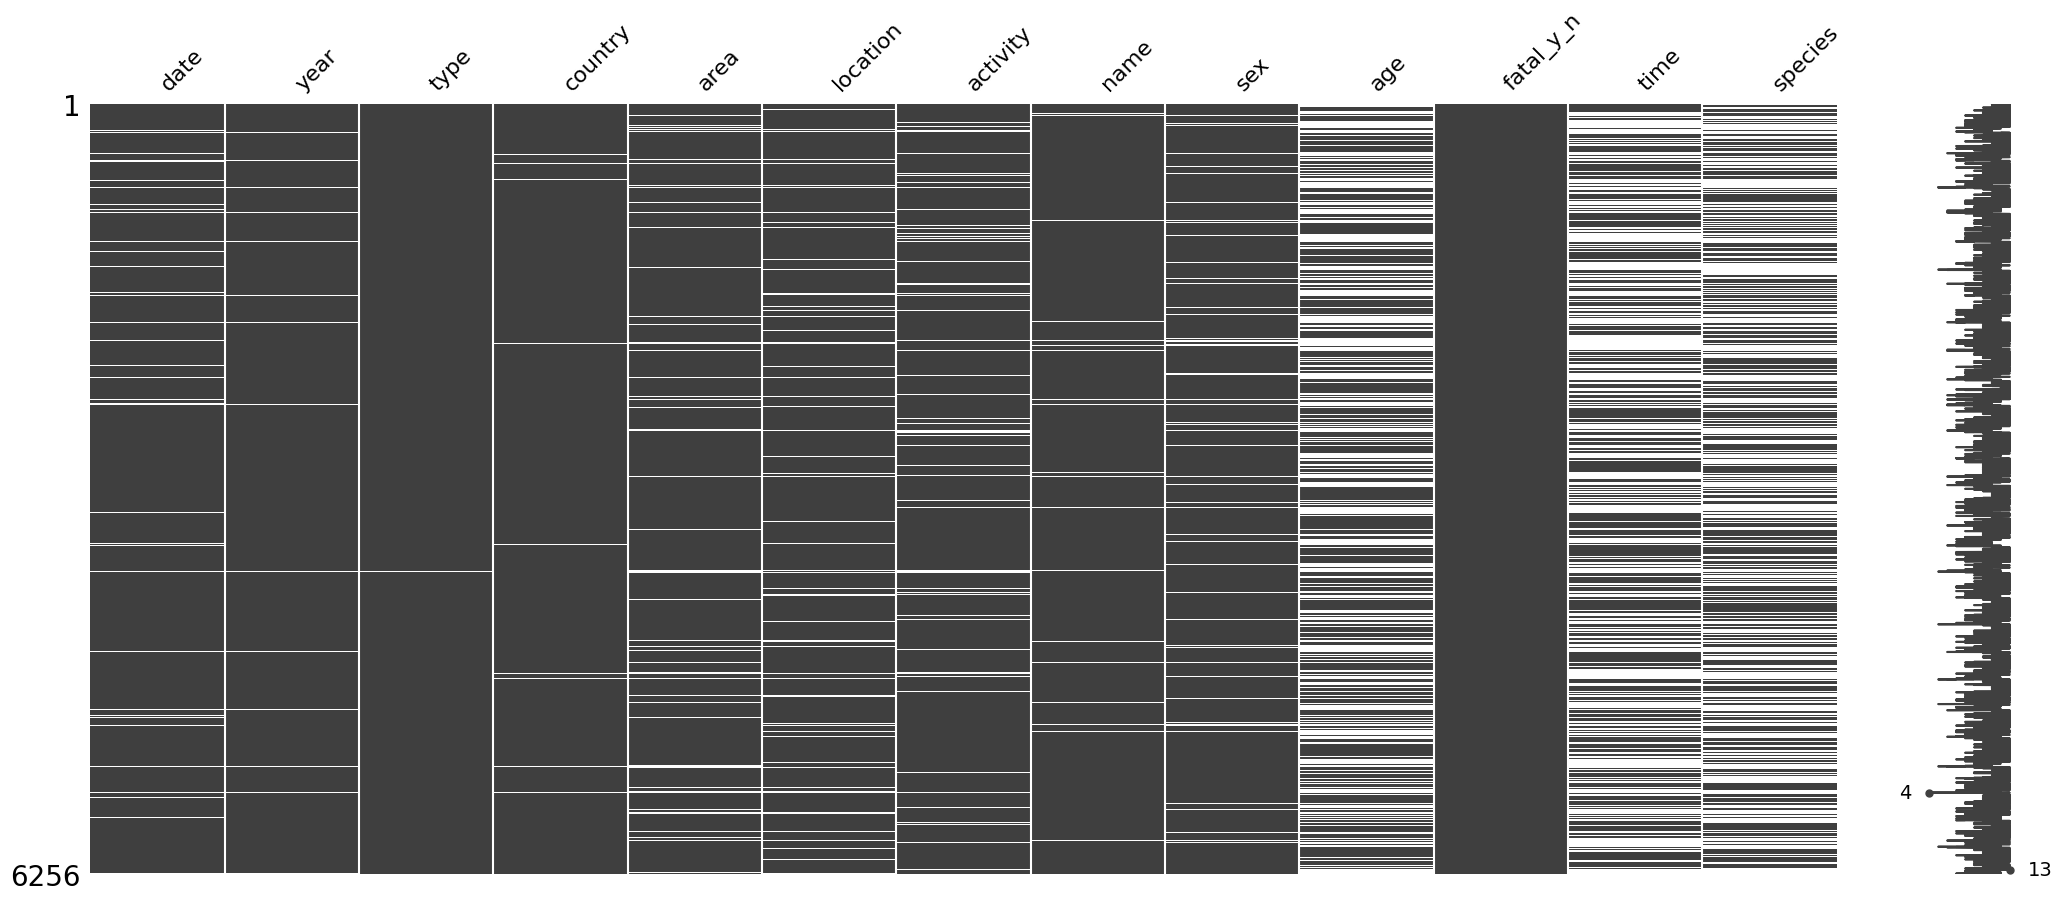

In [37]:
%matplotlib inline
msno.matrix(data)

As we can see in the images above, the white sections show that there are many null values in our dataset. For example, these columns have fewer null values: ['date', 'year', 'type', 'country', 'name', 'fatal_y_n']. But on the other hand, the ['age', 'time', 'species'] columns have a lot of null values. Let's check the datatypes of each column.

In [28]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6890 entries, 0 to 6889
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       6587 non-null   object 
 1   year       6758 non-null   float64
 2   type       6871 non-null   object 
 3   country    6839 non-null   object 
 4   area       6409 non-null   object 
 5   location   6325 non-null   object 
 6   activity   6304 non-null   object 
 7   name       6670 non-null   object 
 8   sex        6318 non-null   object 
 9   age        3903 non-null   object 
 10  fatal_y_n  6890 non-null   object 
 11  time       3372 non-null   object 
 12  species    3772 non-null   object 
dtypes: float64(1), object(12)
memory usage: 699.9+ KB
None


The only column that is numerical is <i>year</i>, so we can use some feature imputation techniques for this column like replace null values with mean, median or a fixed value. For other columns let's check the values to get better insights.

In [39]:
for column in data.columns:
  if data[column].dtype == type(object):
    print(f"{column}: {data[column].unique()}")

date: ['2023-05-13' '2023-04-29' '2022-10-07' ... '1828-01-01' '1792-09-12'
 '1703-03-26']
type: ['Unprovoked' 'Provoked' 'Invalid' 'Watercraft' 'Sea Disaster'
 'Questionable' nan 'Boat' 'Unverified' '?' 'Under investigation']
country: ['AUSTRALIA' 'USA' 'JAMAICA' 'NEW ZEALAND' 'PAPUA NEW GUINEA'
 'FRENCH POLYNESIA' 'CHINA' 'SOUTH AFRICA' 'BAHAMAS' 'NEW CALEDONIA'
 'REUNION' 'PALESTINIAN TERRITORIES' 'BELIZE' 'PHILIPPINES' 'MOZAMBIQUE'
 'KENYA' 'BRAZIL' 'FIJI' 'TANZANIA' 'ENGLAND' 'THAILAND' 'SOUTH KOREA'
 'MAURITIUS' 'ITALY' 'MEXICO' 'MARSHALL ISLANDS' 'SPAIN' 'TAIWAN' 'TURKEY'
 'SENEGAL' 'AMERICAN SAMOA' 'PACIFIC OCEAN' 'INDIAN OCEAN' 'NEW GUINEA'
 'SOLOMON ISLANDS' 'GREECE' 'COSTA RICA' 'INDONESIA' 'CUBA' 'GEORGIA'
 'SIERRA LEONE' 'Coast of AFRICA' 'INDIA' 'TOBAGO' 'EGYPT' 'SAMOA'
 'DOMINICAN REPUBLIC' 'MADAGASCAR' 'MALAYSIA' 'GULF OF ADEN' 'SOMALIA'
 'CHILE' nan 'SINGAPORE' 'BRITISH WEST INDIES' 'NORTH ATLANTIC OCEAN'
 'SRI LANKA' 'OKINAWA' 'SOUTH PACIFIC OCEAN' 'SOUTH ATLANTIC OCE

As we can see in our features, the <i>date</i> and <i>year</i> columns represent the same information and are duplicates, so for the first step, we remove the <i>date</i> column and replace null values in the <i>year</i> column with the average of the years. This dataset is messy, and we need to take a specific action for each column.

In [43]:
if 'date' in data.columns:
    data = data.drop(columns=['date'])
data['year'] = data['year'].fillna(round(data['year'].mean()))

Now for the next step let's focus on <i>type</i> column.

In [45]:
data['type'].value_counts()

type
Unprovoked             4991
Provoked                623
Watercraft              340
Sea Disaster            237
Invalid                  25
Questionable             16
Boat                      7
Unverified                1
?                         1
Under investigation       1
Name: count, dtype: int64

In [51]:
data['type'] = data['type'].replace('?', None)
data = data.dropna(subset=['type'])

Now, for the <i>country, area, location</i> columns, we first remove the location column because, after checking its values, it seems mostly nonsensical and useless. Next, we remove any row where both country and area are None at the same time. Later, I will convert the combination of area and country into latitude and longitude since that will give us more useful information.

In [60]:
if 'location' in data.columns:
    data = data.drop(columns=['location'])
data = data.dropna(subset=['area', 'country'], how='all')

In [81]:
geolocator = Nominatim(user_agent="geo_converter")
def get_latitude_longitude(area, country):
    try:
        location = geolocator.geocode(f"{area}, {country}")
        time.sleep(0.75)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except GeocoderTimedOut:
        return pd.Series([None, None])
    return pd.Series([None, None])

tqdm.pandas()
data[['latitude', 'longitude']] = data.progress_apply(lambda x: get_latitude_longitude(x['area'], x['country']), axis=1)

  0%|          | 0/6212 [00:00<?, ?it/s]

As we can see, the above method takes almost two hours to complete. In order not to wait, I commited the outcome and comitted alongside the jupyter notebook into Github repository. The dataframe can be loaded into data using the following command.

In [83]:
data = pd.read_csv('shark_attacks_lat_long.csv')

In [85]:
if 'area' in data.columns:
     data = data.drop(columns=['area'])
if 'country' in data.columns:
     data = data.drop(columns=['country'])

Now it is time to take a look at <i>latitude</i> and <i>longitude</i> columns, since some of the might be null due to not finding location using geopy API. So we remove rows which there are not any coordinate for them.

In [91]:
data = data.dropna(subset=['latitude', 'longitude'], how='all')

For <i>activity</i> column first we will check the distribution over different values, and we will notice the are some rare values. we will use RareLabelEncoder to convert infrequent values into 'Other'. 

In [105]:
data['activity'].value_counts()

activity
Surfing                                                      1053
Swimming                                                      844
Fishing                                                       439
Other                                                         380
Spearfishing                                                  320
                                                             ... 
Surfing (or sailboarding)                                       1
Surfing & dangling foot in water amid baitfish                  1
Inspecting teeth of supposedly dead (hooked & shot) shark       1
Free diving, collecting shells                                  1
Crew swimming alongside their anchored ship                     1
Name: count, Length: 1242, dtype: int64

In [115]:
data['activity'] = data['activity'].fillna('Other')
rare_encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with='Other', tol=10/data.shape[0])
data['activity'] = rare_encoder.fit_transform(data[['activity']])

For the next step the <i>name</i> column does not have information, because it is the name of person, so we can remove the entire column.

In [117]:
data = data.drop(columns=['name'])

Now, we check the <i>sex</i> column. We remove the columns which do not make sense and only keep 'M' and 'F'.

In [119]:
data['sex'].value_counts()

sex
M        4678
F         655
N           1
.           1
M x 2       1
lli         1
Name: count, dtype: int64

In [120]:
data = data[data['sex'].isin(['M', 'F'])]

For time column, when we look into values, we can see that there are different times, but most of them are in 'hhhmm' format. I decided to apply regex on the time column and change it two categorical variables with these values: ['Morning', 'Noon', 'Evening', 'Night'] and change the rest of the to 'Other'.

In [126]:
def categorize_time(value):
    match = re.match(r'(\d{1,2})h(\d{2})?', str(value))
    if match:
        hour = int(match.group(1))
        if 5 <= hour < 12:
            return "Morning"
        elif 12 <= hour < 17:
            return "Noon"
        elif 17 <= hour < 21:
            return "Evening"
        else:
            return "Night"
    else:
        return "Other" 
data['time'] = data['time'].apply(categorize_time)

For the <i>species</i> column again we will use RareLabelEncoder to encode infrequent values into 'Other'

In [132]:
data['species'].value_counts()

species
White shark                       149
Tiger shark                        74
Bull shark                         62
4' shark                           42
6' shark                           42
                                 ... 
1.5 m [5'] hammerhead shark         1
Sevengill shark, 2.4 m              1
White shark, 5 m                    1
1.8 m [6'] grey reef shark          1
Said to be a 7.6 m [25'] shark      1
Name: count, Length: 1328, dtype: int64

In [137]:
data['species'] = data['species'].fillna('Other')
rare_encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with='Other', tol=25/data.shape[0])
data['species'] = rare_encoder.fit_transform(data[['species']])

In [143]:
data['species'].value_counts()

species
Other               4771
White shark          149
Tiger shark           74
Bull shark            62
6' shark              42
4' shark              42
1.8 m [6'] shark      34
1.5 m [5'] shark      29
3' shark              27
Wobbegong shark       26
4' to 5' shark        26
1.2 m [4'] shark      26
5' shark              25
Name: count, dtype: int64

For the last feature age, since originally this column should be of type int, but it is object and there are lots of null values, I decided to classify ages that have int type and others that is nonsense to 'Others'.

In [144]:
def classify_age(age):
    if pd.isna(age):
        return 'Others'
    elif age <= 12:
        return 'Child'
    elif age <= 19:
        return 'Teenager'
    elif age <= 35:
        return 'Young Adult'
    elif age <= 55:
        return 'Middle-aged Adult'
    else:
        return 'Senior'
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['age'] = data['age'].apply(classify_age)

Now that we cleaned all of our features, it is time to again check the <i>missingno</i> plot, and save our cleaned dataframe.

<Axes: >

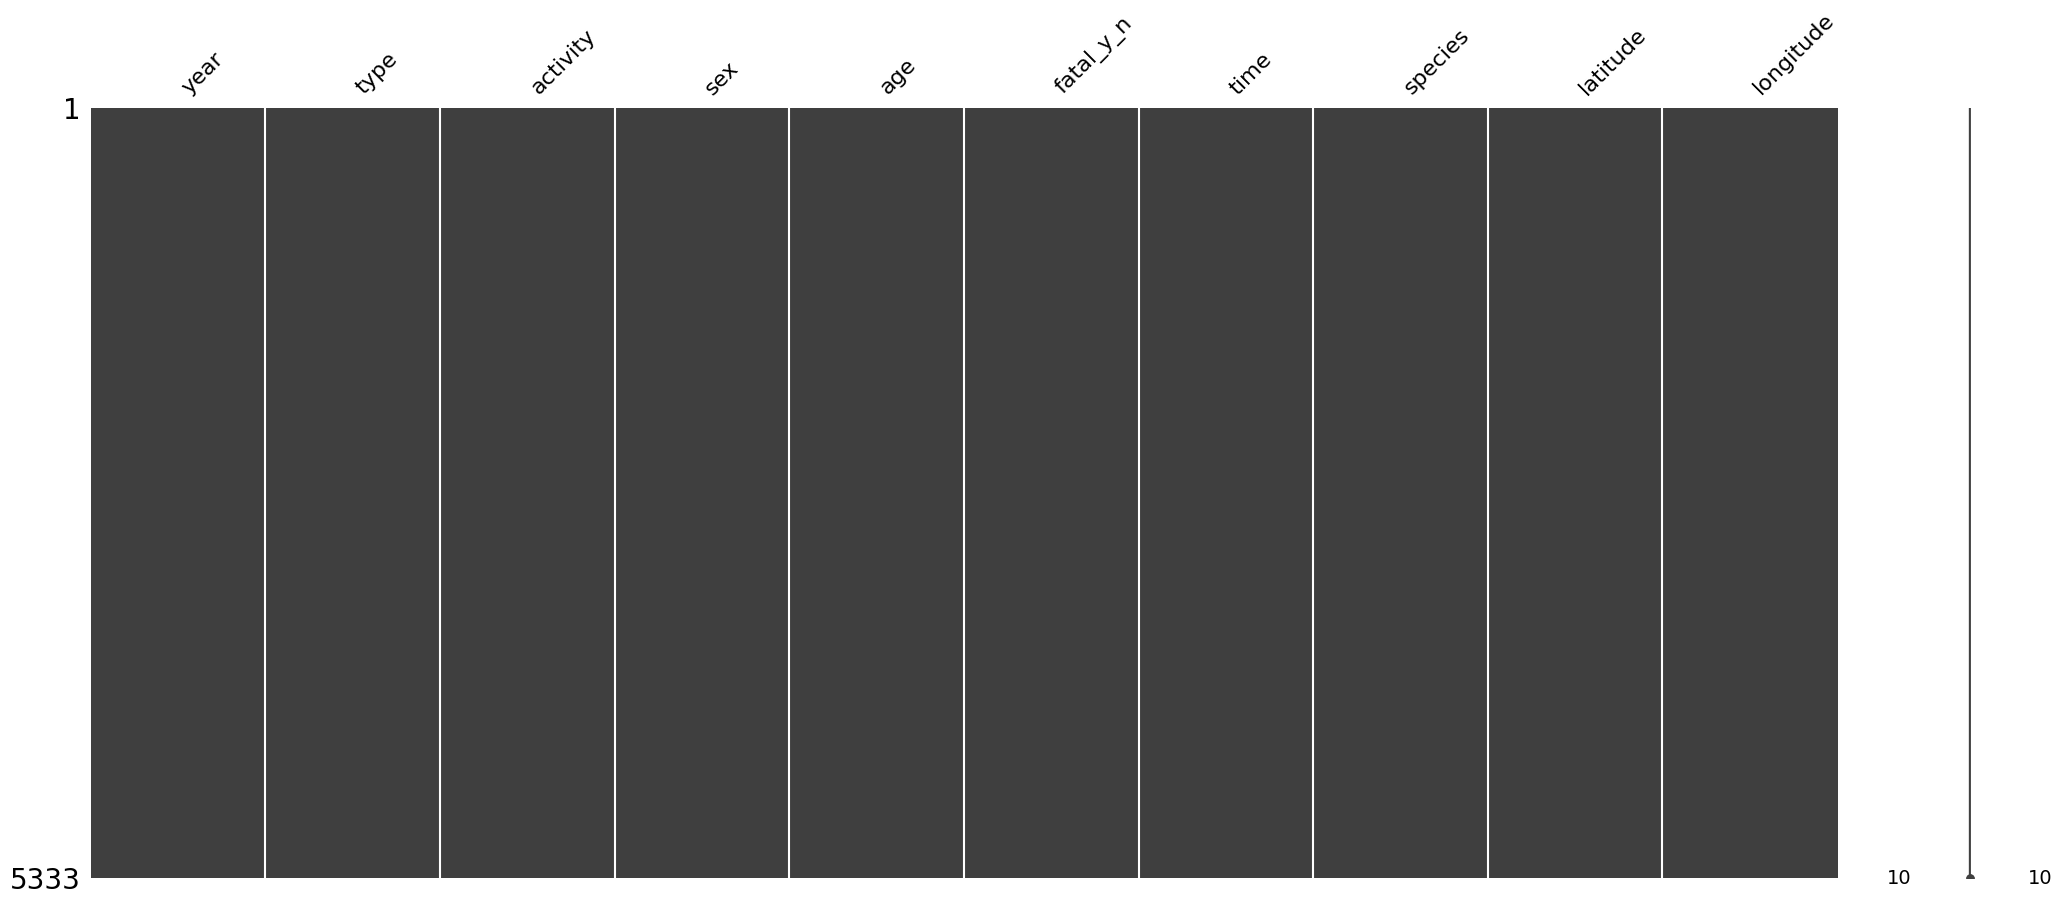

In [146]:
%matplotlib inline
msno.matrix(data)

As the above image shows us, now we have clean and none null values in our features. The original length of our data was 6890 and after cleaning is 5333 so we had to ignore 1557 rows.

In [147]:
data.to_csv('shark_attacks_clean.csv')